In [1]:
# ------------------------------------
#  Eepa Flux with Skin & Diffuseness
#     Bayesian NN + Active Learning (b included)
# ------------------------------------

import numpy as np
from scipy.integrate import quad, dblquad
from scipy.special import kv, spherical_jn
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from functools import lru_cache

# Enable CPU optimizations
tf.config.optimizer.set_jit(True)
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)

# ------------------------------
#  Hyperparameters & Priors
# ------------------------------
INITIAL_SAMPLES   = 200   # seed dataset size
ACTIVE_ROUNDS     = 100    # max active‐learning iterations
EPOCHS_PER_ROUND  = 10    # training epochs per round
BATCH_SIZE        = 64    # batch size for training
MC_SAMPLES        = 100   # MC dropout samples for uncertainty

# Nuclear skin & diffuseness priors
DELTA_R_MEAN, DELTA_R_SIGMA = 0.283, 0.071
A_MEAN,     A_SIGMA         = 0.546, 0.010

# Physical constants for EPA
ALPHA, Z = 1/137.036, 82
GAMMA    = 2950.0    # Lorentz factor
R_NUC    = 7.0       # nuclear radius (fm)
M_JPSI   = 3.0969    # J/ψ mass (GeV)

# ------------------------------
#  Hyperparameters & Constants
# ------------------------------
R0_WS    = 6.62       # Woods–Saxon radius (fm)
a_WS     = 0.546      # Woods–Saxon skin thickness (fm)
# GAMMA    = 2950.0     # Lorentz factor
# Z        = 82         # nuclear charge
# ALPHA    = 1/137.036  # fine‐structure constant
# R_NUC    = 7.0        # nuclear radius cutoff for integration (fm)
B_FIXED  = 20.0       # fixed impact parameter for example plots (fm)
# M_JPSI   = 3.0969     # J/ψ mass (GeV)


In [2]:
# ------------------------------
#  Robust 1D integrator
# ------------------------------
def robust_quad(func, a, b, **kwargs):
    """
    Wrapper around scipy.quad: if it fails, falls back to trapezoidal rule.
    """
    from scipy.integrate import quad
    try:
        return quad(func, a, b, **kwargs)[0]
    except Exception:
        xs = np.linspace(a, b, 200)
        ys = np.array([func(x) for x in xs])
        return np.trapz(ys, xs)

# ------------------------------
#  Woods–Saxon 3D density
# ------------------------------
def rho_ws_3d(r, R0=R0_WS, a=a_WS):
    """Woods–Saxon 3D density (unnormalized)."""
    return 1.0 / (1.0 + np.exp((r - R0) / a))

# ------------------------------
#  Projected 2D density ρ₂D(R)
# ------------------------------
@lru_cache(maxsize=256)
def rho_ws_2d(R, R0=R0_WS, a=a_WS):
    """
    Projected density at radius R: ∫_{−∞}^{+∞} dz ρ_ws_3d(sqrt(R²+z²)).
    """
    integrand = lambda z: rho_ws_3d(np.hypot(R, z), R0, a)
    # integrate z over ±10a (captures >99% of tail)
    return robust_quad(integrand, -10*a, +10*a, epsabs=1e-6, epsrel=1e-6)

# Precompute normalization constant for ρ₂D so that ∫0^∞ 2πR ρ₂D(R)dR = 1
def compute_rho2d_norm(R0=R0_WS, a=a_WS):
    integrand = lambda R: 2*np.pi * R * rho_ws_2d(R, R0, a)
    # integrate R∈[0, R_NUC+5a] for safety
    total = robust_quad(integrand, 0, R_NUC + 5*a, epsabs=1e-6, epsrel=1e-6)
    return 1.0 / total

RHO2D_NORM = compute_rho2d_norm()

def rho_ws_2d_norm(R, R0=R0_WS, a=a_WS):
    """Normalized projected density ρ₂D(R), ∫2πR dR ρ₂D=1."""
    return RHO2D_NORM * rho_ws_2d(R, R0, a)

# ------------------------------
#  Point‐Charge EPA Kernel n(ω,b)
# ------------------------------
def epa_point_flux(omega, b, gamma=GAMMA, Z=Z, alpha=ALPHA):
    """
    STARlight/EDFF point‐charge flux:
      n(ω,b) = (Z²α)/(π² b²) ξ² [K1(ξ)² + (1/γ²) K0(ξ)²],
      with ξ = ω b / γ.
    """
    xi = omega * b / gamma
    pref = (Z**2 * alpha) / (np.pi**2 * b**2) * xi**2
    return pref * (kv(1, xi)**2 + (1.0/gamma**2) * kv(0, xi)**2)


In [3]:
# ------------------------------
#  Real‐Space Convolution EPA
# ------------------------------
import warnings
def compute_eepa_flux_real(omega, b, R0=R0_WS, a=a_WS):
    """
    Compute equivalent‐photon flux N(ω,b) by real‐space convolution:
      N(ω,b) = ∫ dφ ∫ dR [ n_pt(ω, |b+R e^{iφ}| ) × ρ₂D(R) ] R dR dφ
    Returns flux density in fm⁻².
    """
    def integrand(phi, R):
        # distance from element at (R,φ) to point at impact parameter b
        d = np.hypot(b + R*np.cos(phi), R*np.sin(phi))
        # point‐charge kernel
        npt = epa_point_flux(omega, d)
        # normalized projected density
        rho2d = rho_ws_2d_norm(R, R0, a)
        return npt * rho2d * R

    # 2D integration over R∈[0,R_NUC], φ∈[0,2π]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return dblquad(
            integrand,
            0, R_NUC,
            lambda R: 0,
            lambda R: 2*np.pi
        )[0]

# Rapidities ↔ Photon Energies
def rapidity_to_omega(y): return (M_JPSI/2) * np.exp(y)
def omega_to_rapidity(omega): return np.log(2*omega/M_JPSI)


In [4]:
# ------------------------------
#  Initial Dataset Creation
# ------------------------------
# def create_initial_dataset(n=INITIAL_SAMPLES):
#     y_min, y_max = -4, 4
#     ω_min, ω_max = rapidity_to_omega(y_min), rapidity_to_omega(y_max)
#     logω = np.random.uniform(np.log(ω_min), np.log(ω_max), n)
#     ω    = np.exp(logω)
#     b      = np.full(n, B_FIXED)       # constant impact parameter
#     b_norm = np.zeros_like(b, dtype=np.float32)  # normalized b is all zeros

#     # b = np.full(n, B_FIXED)
#     # b_norm = np.zeros_like(b)    # since b is constant, its "normalized" value is zero
#     ΔR   = np.random.normal(DELTA_R_MEAN, DELTA_R_SIGMA, n)
#     a_vals = np.random.normal(A_MEAN, A_SIGMA, n)
#     R0   = 6.62 + ΔR
#     flux = np.array([compute_eepa_flux_real(o, bb, r0, aa)
#                      for o, bb, r0, aa in zip(ω, b, R0, a_vals)])

#     # X = np.vstack([
#     #     logω,
#     #     (b    - b.mean())     / b.std(),
#     #     (ΔR   - DELTA_R_MEAN) / DELTA_R_SIGMA,
#     #     (a_vals - A_MEAN)     / A_SIGMA
#     # ]).T.astype(np.float32)
#     X = np.vstack([
#         logω,
#         b_norm,                        # use zeros in place of (b-b.mean)/b.std
#         (ΔR    - DELTA_R_MEAN) / DELTA_R_SIGMA,
#         (a_vals - A_MEAN)     / A_SIGMA
#     ]).T.astype(np.float32)

#     Y = np.log(flux + 1e-30).astype(np.float32).reshape(-1,1)
#     return X, Y

# ------------------------------
#  Initial Dataset Creation
#  (with b fixed → zero feature)
# ------------------------------
def create_initial_dataset(n=INITIAL_SAMPLES):
    """
    Seed dataset at fixed impact parameter B_FIXED.
    Features: [ logω,  b_norm=0,  ΔR_norm,  a_norm ].
    Targets:  log(flux).
    """
    # 1) sample ω via log-uniform over y=[−4,4]
    ys       = np.random.uniform(-4, 4, n)
    ωs       = rapidity_to_omega(ys)
    logω     = np.log(ωs)

    # 2) fixed b → zero-vector feature
    b_fixed  = np.full(n, B_FIXED, dtype=np.float32)
    b_norm   = np.zeros(n,           dtype=np.float32)

    # 3) nuclear priors
    ΔR       = np.random.normal(DELTA_R_MEAN, DELTA_R_SIGMA, n)
    a_vals   = np.random.normal(A_MEAN,       A_SIGMA,       n)
    R0       = 6.62 + ΔR

    # 4) compute true flux via real-space WS convolution
    flux     = np.array([
        compute_eepa_flux_real(o, B_FIXED, r0, aa)
        for o, r0, aa in zip(ωs, R0, a_vals)
    ], dtype=np.float32)

    # 5) stack features
    X = np.vstack([
        logω.astype(np.float32),
        b_norm,
        ((ΔR   - DELTA_R_MEAN) / DELTA_R_SIGMA).astype(np.float32),
        ((a_vals - A_MEAN)       / A_SIGMA).astype(np.float32)
    ]).T  # shape (n,4)

    # 6) build targets
    Y = np.log(flux + 1e-30).reshape(-1,1)

    return X, Y



# ------------------------------
#  Bayesian Neural Network
# ------------------------------
def build_bnn(input_dim=4, hidden=128, drop_rate=0.1):
    inp = layers.Input(shape=(input_dim,))
    x   = layers.Dense(hidden, activation='relu')(inp)
    x   = layers.Dropout(drop_rate)(x, training=True)
    x   = layers.Dense(hidden, activation='relu')(x)
    x   = layers.Dropout(drop_rate)(x, training=True)
    mu  = layers.Dense(1)(x)
    lv  = layers.Dense(1)(x)
    return models.Model(inp, [mu, lv])

@tf.function
def gaussian_nll(y_true, mu, logvar):
    var = tf.exp(logvar)
    return tf.reduce_mean(0.5 * (logvar + (y_true - mu)**2 / var))

# MC-Dropout inference
def predict_with_uncertainty(model, X, n_samples=MC_SAMPLES):
    preds, vars_ = [], []
    for _ in range(n_samples):
        mu, lv = model(X, training=True)
        lv = tf.clip_by_value(lv, -3.0, 2.0)
        preds.append(mu.numpy())
        vars_.append(np.exp(lv.numpy()))
    P = np.stack(preds)
    V = np.stack(vars_)
    mean = P.mean(axis=0).squeeze()
    epi  = P.var(axis=0).squeeze()
    alea = V.mean(axis=0).squeeze()
    return mean, np.sqrt(epi + alea)


In [5]:
# # ------------------------------
# #  Active Sampling Function
# # ------------------------------
# def active_sample(X, Y, model, k=50, n_cand=500):
#     y_min, y_max = -4,4
#     ω_min, ω_max = rapidity_to_omega(y_min), rapidity_to_omega(y_max)
#     logω_uni = np.random.uniform(np.log(ω_min), np.log(ω_max), n_cand//2)
#     ω_uni     = np.exp(logω_uni)
#     ys_grid = np.linspace(y_min, y_max, 100)
#     ω_grid  = rapidity_to_omega(ys_grid)
#     b_c    = np.full(n_cand, B_FIXED)

#     # b_cand  = B_FIXED
#     # b_cand  = np.random.uniform(10,100,n_cand)
#     # b_cand = np.full(n_cand, B_FIXED)
#     # Xg = np.vstack([
#     #     np.log(ω_grid),
#     #     np.full_like(ys_grid, (b_cand.mean() - b_cand.mean())/b_cand.std()),
#     #     np.zeros_like(ys_grid),
#     #     np.zeros_like(ys_grid)
#     # ]).T.astype(np.float32)
#     # b_cand = np.full(n_cand, B_FIXED)
#     # b0     = np.zeros_like(ys_grid, dtype=np.float32)  # normalized b = 0
#     # Xg = np.vstack([
#     #     np.log(ω_grid),
#     #     b0,                           # all zeros
#     #     np.zeros_like(ys_grid),       # ΔR_norm=0
#     #     np.zeros_like(ys_grid)        # a_norm=0
#     # ]).T.astype(np.float32)

#     # For fixed b, normalized b_feature is always zero:
#     b0 = np.zeros_like(ys_grid, dtype=np.float32)
#     Xg = np.vstack([
#         np.log(ω_grid),
#         b0,
#         np.zeros_like(ys_grid),
#         np.zeros_like(ys_grid)
#     ]).T.astype(np.float32)

#     _, std_g = predict_with_uncertainty(model, Xg)
#     # p_tail   = std_g.clip(min=0)
#     # p_tail  /= p_tail.sum()

#     # Build a proper probability vector
#     p_tail = std_g.clip(min=0)
#     total  = p_tail.sum()
#     if total > 0:
#         p_tail /= total
#     else:
#         # if the network is completely sure everywhere, sample uniformly
#         p_tail = np.full_like(p_tail, 1.0 / len(p_tail))

#     y_tail   = np.random.choice(ys_grid, size=n_cand//2, p=p_tail)
#     ω_tail   = rapidity_to_omega(y_tail)
#     ω_c = np.concatenate([ω_uni, ω_tail])
#     # b_c = B_FIXED
#     # b_c = np.full(n_cand, B_FIXED)
#     # b_c = np.random.uniform(10,100,n_cand)
#     ΔR_c = np.random.normal(DELTA_R_MEAN, DELTA_R_SIGMA, n_cand)
#     a_c   = np.random.normal(A_MEAN, A_SIGMA, n_cand)
#     R0_c  = 6.62 + ΔR_c
#     # Xc = np.vstack([
#     #     np.log(ω_c),
#     #     (b_c    - b_c.mean())     / b_c.std(),
#     #     (ΔR_c   - DELTA_R_MEAN) / DELTA_R_SIGMA,
#     #     (a_c    - A_MEAN)       / A_SIGMA
#     # ]).T.astype(np.float32)
#     # b_c = np.full(n_cand, B_FIXED)
#     # b0c = np.zeros_like(b_c, dtype=np.float32)
#     # Xc = np.vstack([
#     #     np.log(ω_c),
#     #     b0c,                          # all zeros
#     #     (ΔR_c - DELTA_R_MEAN)/DELTA_R_SIGMA,
#     #     (a_c - A_MEAN)/A_SIGMA
#     # ]).T.astype(np.float32)
#     # fixed b again → feature zeros
#     b0c = np.zeros(n_cand, dtype=np.float32)
#     Xc = np.vstack([
#         np.log(ω_c),
#         b0c,
#         (ΔR_c - DELTA_R_MEAN) / DELTA_R_SIGMA,
#         (a_c  - A_MEAN)       / A_SIGMA
#     ]).T.astype(np.float32)

#     _, std_c = predict_with_uncertainty(model, Xc)
#     idx = np.argsort(std_c)[-k:]
#     flux_new = np.array([
#         compute_eepa_flux_real(ω_c[i], b_c[i], R0_c[i], a_c[i]) for i in idx
#     ])
#     X_new = Xc[idx]
#     Y_new = np.log(flux_new + 1e-30).astype(np.float32).reshape(-1,1)
#     return np.vstack([X, X_new]), np.vstack([Y, Y_new])


In [6]:
def active_sample(X, Y, model, k=50, n_cand=500):
    """
    Propose new points by mixing half uniform-logω and half tail-focused.
    All b are fixed to B_FIXED, so b_norm=0 always.
    """
    # uniform‐ω half
    y_min, y_max = -4, 4
    ω_min, ω_max = rapidity_to_omega(y_min), rapidity_to_omega(y_max)
    logω_uni  = np.random.uniform(np.log(ω_min), np.log(ω_max), n_cand//2)
    ω_uni     = np.exp(logω_uni)

    # tail‐focused ω half
    ys_grid = np.linspace(y_min, y_max, 100)
    ω_grid  = rapidity_to_omega(ys_grid)
    # build grid features (b_norm=0, ΔR_norm=0, a_norm=0)
    Xg = np.vstack([
        np.log(ω_grid).astype(np.float32),
        np.zeros_like(ys_grid, dtype=np.float32),
        np.zeros_like(ys_grid, dtype=np.float32),
        np.zeros_like(ys_grid, dtype=np.float32)
    ]).T
    _, std_g = predict_with_uncertainty(model, Xg)

    # safe tail‐sampling probabilities
    p_tail = np.clip(std_g, 0, None)
    if p_tail.sum() > 0:
        p_tail /= p_tail.sum()
    else:
        p_tail = np.full_like(p_tail, 1/len(p_tail))

    y_tail   = np.random.choice(ys_grid, size=n_cand//2, p=p_tail)
    ω_tail   = rapidity_to_omega(y_tail)

    # concatenate candidates
    ω_c  = np.concatenate([ω_uni, ω_tail])

    # sample nuclear priors for each candidate
    ΔR_c  = np.random.normal(DELTA_R_MEAN, DELTA_R_SIGMA, n_cand)
    a_c   = np.random.normal(A_MEAN,       A_SIGMA,       n_cand)
    R0_c  = 6.62 + ΔR_c

    # build candidate feature matrix (b_norm=0)
    Xc = np.vstack([
        np.log(ω_c).astype(np.float32),
        np.zeros(n_cand, dtype=np.float32),
        ((ΔR_c - DELTA_R_MEAN)/DELTA_R_SIGMA).astype(np.float32),
        ((a_c  - A_MEAN)      /A_SIGMA).astype(np.float32)
    ]).T

    # rank by predicted uncertainty
    _, std_c = predict_with_uncertainty(model, Xc)
    idx      = np.argsort(std_c)[-k:]

    # compute true fluxes only for selected idx
    flux_new = np.array([
        compute_eepa_flux_real(ω_c[i], B_FIXED, R0_c[i], a_c[i])
        for i in idx
    ], dtype=np.float32)

    X_new = Xc[idx]
    Y_new = np.log(flux_new + 1e-30).reshape(-1,1)

    return np.vstack([X,    X_new]), \
           np.vstack([Y,    Y_new])


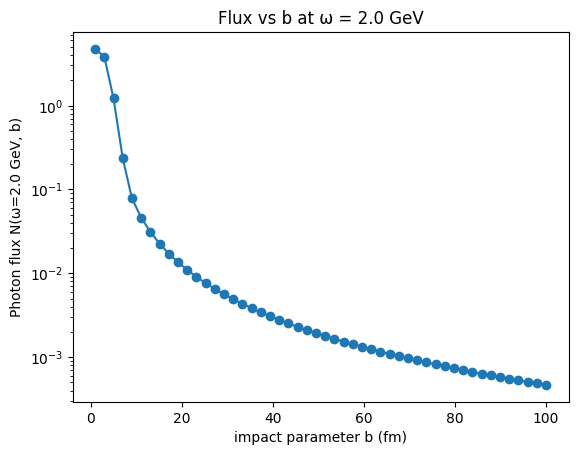

In [7]:
def plot_flux_vs_b(energy=2.0, R0=6.62, a=A_MEAN, b_range=(1,100), n_points=50):
    bs = np.linspace(*b_range, n_points)
    flux_vals = [compute_eepa_flux_real(energy, bv, 6.62, A_MEAN) for bv in bs]
    plt.figure()
    plt.plot(bs, flux_vals, '-o')
    plt.xlabel('impact parameter b (fm)')
    plt.ylabel(f'Photon flux N(ω={energy} GeV, b)')
    plt.title(f'Flux vs b at ω = {energy} GeV')
    plt.yscale('log')
    plt.show()

plot_flux_vs_b()

In [8]:
def edff_flux(omega, b, R0=6.62, a=0.546, gamma=GAMMA, Z=Z, alpha=ALPHA):
    """
    Analytical EPA flux (EDFF / STARlight formula):
      N_EDFF(ω,b) = (Z^2 α)/(π^2) * (ξ^2/b^2)
                    * [K1(ξ)^2 + (1/γ^2) K0(ξ)^2]
    with ξ = ω b / γ. Returns N in fm^{-2}.
    """
    xi   = omega * b / gamma
    pref = (Z**2 * alpha)/(np.pi**2) * (xi**2 / b**2)
    return pref * (kv(1, xi)**2 + (1.0/gamma**2)*kv(0, xi)**2)


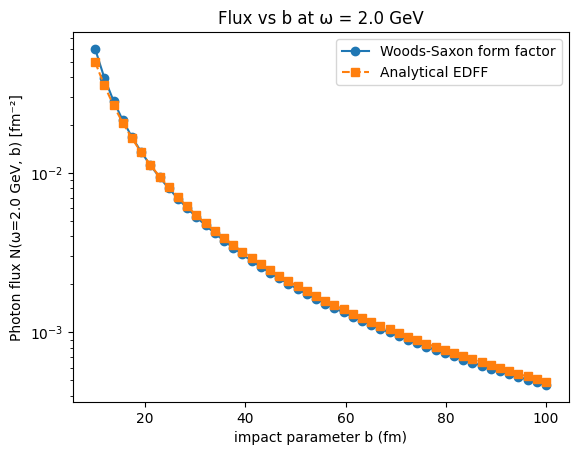

In [28]:
def plot_flux_vs_b(energy=2.0, R0=6.62, a=A_MEAN,
                   b_range=(10.0, 100.0), n_points=50):
    """
    Plot photon flux N(ω, b) vs impact parameter b for a fixed photon energy ω.
    Compares the full numeric Woods–Saxon EPA to the analytical EDFF formula.
    """
    bs = np.linspace(b_range[0], b_range[1], n_points)

    # numeric EPA with Woods–Saxon form factor
    flux_num = [compute_eepa_flux_real(energy, b, R0, a) for b in bs]
    # analytical EDFF / STARlight
    flux_edff = [edff_flux(energy, b, R0, a) for b in bs]

    plt.figure()
    plt.plot(bs, flux_num, 'o-',  label='Woods-Saxon form factor')
    plt.plot(bs, flux_edff,'s--', label='Analytical EDFF')
    plt.yscale('log')
    plt.xlabel('impact parameter b (fm)')
    plt.ylabel(f'Photon flux N(ω={energy} GeV, b) [fm⁻²]')
    plt.title(f'Flux vs b at ω = {energy} GeV')
    plt.legend()
    plt.savefig('fluxes.pdf')
    plt.show()

# Usage example:
plot_flux_vs_b(energy=2.0)


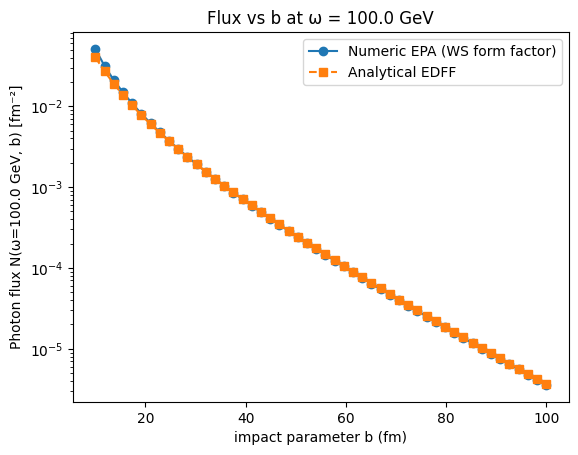

In [10]:
plot_flux_vs_b(energy=100.0)

In [19]:
# ------------------------------
#  Active Learning Training
# ------------------------------
def active_learning_train():
    X, Y   = create_initial_dataset()
    model  = build_bnn()
    opt    = optimizers.Adam(1e-3)
    history = {'train_nll': [], 'val_nll': []}
    for round_idx in range(ACTIVE_ROUNDS):
        ds = tf.data.Dataset.from_tensor_slices((X, Y))
        ds = ds.shuffle(500).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
        for _ in range(EPOCHS_PER_ROUND):
            for xb, yb in ds:
                with tf.GradientTape() as tape:
                    mu, lv = model(xb, training=True)
                    loss   = gaussian_nll(yb, mu, lv)
                opt.apply_gradients(zip(tape.gradient(loss,model.trainable_variables),model.trainable_variables))
        mu_t, lv_t = model(X, training=False)
        history['train_nll'].append(gaussian_nll(Y, mu_t, lv_t).numpy())
        ys = np.linspace(-4,4,50); ωs = rapidity_to_omega(ys)
        # bs = B_FIXED
        # FIX b for evaluation:
        bs = np.full_like(ys, B_FIXED)
        b_norm = np.zeros_like(bs)

        # bs = np.linspace(10,100,50)
        # Plot rough flux vs b
        # flux_b = [compute_eepa_flux(ωs[25], b_val, 6.62, A_MEAN) for b_val in bs]
        # plt.figure(); plt.plot(bs, flux_b); plt.xlabel('b (fm)'); plt.ylabel('N(ω_mid,b)'); plt.title('Flux vs impact parameter'); plt.show()
        # X_eval = np.vstack([
        #     np.log(ωs),
        #     bs,
        #     # (bs - bs.mean())/bs.std(),
        #     np.zeros_like(ys),
        #     np.zeros_like(ys)
        # ]).T.astype(np.float32)

        X_eval = np.vstack([
            np.log(ωs),
            b_norm,                   # zeros
            np.zeros_like(ys),        # ΔR_norm=0
            np.zeros_like(ys)         # a_norm=0
        ]).T.astype(np.float32)

        _, std = predict_with_uncertainty(model, X_eval)
        rel_unc = np.sqrt(np.exp(std**2) - 1)
        history['val_nll'].append(gaussian_nll(Y, mu_t, lv_t).numpy())
        max_unc = rel_unc.max()
        print(f"Round {round_idx}: max rel. unc = {max_unc:.3f}")
        if max_unc < 0.150:
            print("Stopping early: 15% target reached")
            break
        X, Y = active_sample(X, Y, model)
    return model, history


In [20]:
ACTIVE_ROUNDS  = 100
model, history = active_learning_train()
model.save('eepa_flux_bnn3d_real.keras')

Round 0: max rel. unc = 43.068
Round 1: max rel. unc = 21.795
Round 2: max rel. unc = 1.494
Round 3: max rel. unc = 1.167
Round 4: max rel. unc = 0.716
Round 5: max rel. unc = 0.604
Round 6: max rel. unc = 0.512
Round 7: max rel. unc = 0.467
Round 8: max rel. unc = 0.421
Round 9: max rel. unc = 0.412
Round 10: max rel. unc = 0.376


2025-07-07 17:39:32.734245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Round 11: max rel. unc = 0.370
Round 12: max rel. unc = 0.353
Round 13: max rel. unc = 0.350
Round 14: max rel. unc = 0.342
Round 15: max rel. unc = 0.319
Round 16: max rel. unc = 0.322
Round 17: max rel. unc = 0.311
Round 18: max rel. unc = 0.300
Round 19: max rel. unc = 0.308
Round 20: max rel. unc = 0.299
Round 21: max rel. unc = 0.300
Round 22: max rel. unc = 0.295
Round 23: max rel. unc = 0.291
Round 24: max rel. unc = 0.290
Round 25: max rel. unc = 0.282
Round 26: max rel. unc = 0.285
Round 27: max rel. unc = 0.283
Round 28: max rel. unc = 0.278
Round 29: max rel. unc = 0.277
Round 30: max rel. unc = 0.281
Round 31: max rel. unc = 0.278
Round 32: max rel. unc = 0.272
Round 33: max rel. unc = 0.276
Round 34: max rel. unc = 0.274
Round 35: max rel. unc = 0.270
Round 36: max rel. unc = 0.267
Round 37: max rel. unc = 0.271
Round 38: max rel. unc = 0.263
Round 39: max rel. unc = 0.268
Round 40: max rel. unc = 0.264
Round 41: max rel. unc = 0.260
Round 42: max rel. unc = 0.259
Round 43

2025-07-07 17:43:38.850427: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Round 62: max rel. unc = 0.235
Round 63: max rel. unc = 0.233
Round 64: max rel. unc = 0.232
Round 65: max rel. unc = 0.232
Round 66: max rel. unc = 0.231
Round 67: max rel. unc = 0.231
Round 68: max rel. unc = 0.232
Round 69: max rel. unc = 0.230
Round 70: max rel. unc = 0.230
Round 71: max rel. unc = 0.230
Round 72: max rel. unc = 0.229
Round 73: max rel. unc = 0.229
Round 74: max rel. unc = 0.228
Round 75: max rel. unc = 0.229
Round 76: max rel. unc = 0.228
Round 77: max rel. unc = 0.228
Round 78: max rel. unc = 0.229
Round 79: max rel. unc = 0.228
Round 80: max rel. unc = 0.228
Round 81: max rel. unc = 0.228
Round 82: max rel. unc = 0.228
Round 83: max rel. unc = 0.228
Round 84: max rel. unc = 0.229
Round 85: max rel. unc = 0.228
Round 86: max rel. unc = 0.228
Round 87: max rel. unc = 0.228
Round 88: max rel. unc = 0.227
Round 89: max rel. unc = 0.228
Round 90: max rel. unc = 0.228
Round 91: max rel. unc = 0.228
Round 92: max rel. unc = 0.228
Round 93: max rel. unc = 0.228
Round 94

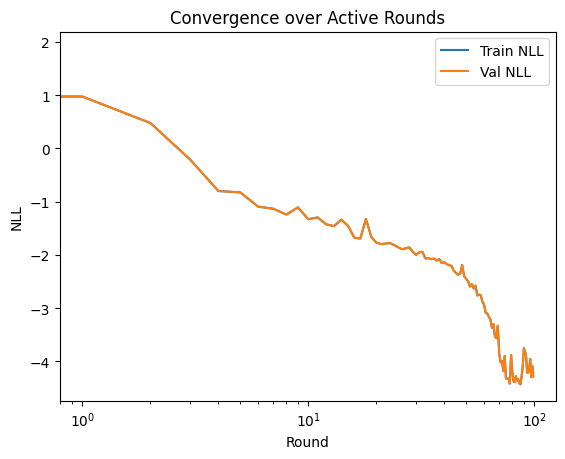

In [29]:
# --- 9. Plot NLL vs Epoch --------------------------------------------------
plt.figure()
plt.plot(history['train_nll'], label='Train NLL')
plt.plot(history['val_nll'], label='Val NLL')
plt.xlabel('Round')
plt.xscale('log')
plt.ylabel('NLL')
plt.title('Convergence over Active Rounds')
plt.legend()
plt.savefig('converfence.pdf')


In [14]:
# ACTIVE_ROUNDS     = 41    # max active‐learning iterations
# model, history = active_learning_train()
# model.save('eepa_flux_bnn3d_real.keras')

In [40]:
model2 = build_bnn()
model2 = models.load_model('eepa_flux_bnn3d_real.keras', compile=False)


/Users/simoneragoni/aliceO2/ML-autoencoder-2/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_2']
Received: inputs=Tensor(shape=(50, 4))
  warnings.warn(msg)


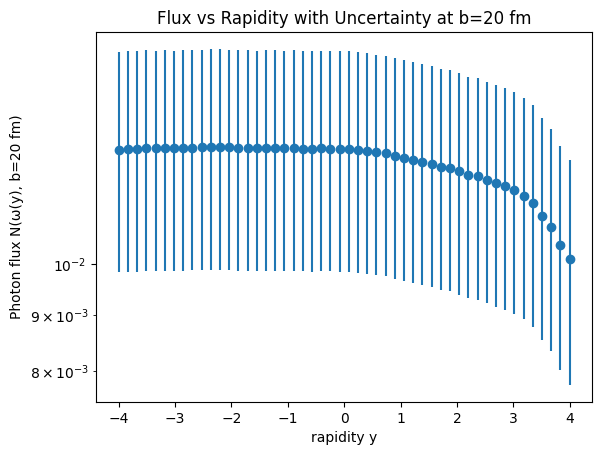

In [43]:
# ------------------------------
#  Final Rapid vs Rapidity & Uncertainty (with b variation)
# ------------------------------
ys = np.linspace(-4, 4, 50)
omega_vals = rapidity_to_omega(ys)
b_vals = np.linspace(10, 100, 50)

# Prepare feature grid for flux vs y at fixed b=20 (e.g., mid b index)
b_fixed = 20.0
X_flux_y = np.vstack([
    np.log(omega_vals),
    np.full_like(ys, (b_fixed - b_vals.mean()) / b_vals.std()),
    np.zeros_like(ys),  # ΔR_norm=0
    np.zeros_like(ys)   # a_norm=0
]).T.astype(np.float32)
mu_y, std_y = predict_with_uncertainty(model2, X_flux_y)
flux_y = np.exp(mu_y)
rel_unc_y = np.sqrt(np.exp(std_y**2) - 1)

plt.figure()
plt.errorbar(ys, flux_y, yerr=flux_y * rel_unc_y, fmt='o')
plt.yscale('log')
plt.xlabel('rapidity y')
plt.ylabel('Photon flux N(ω(y), b=20 fm)')
plt.title('Flux vs Rapidity with Uncertainty at b=20 fm')
plt.show()

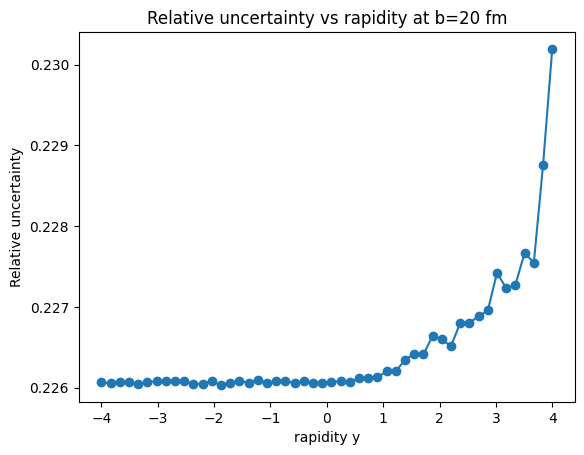

In [44]:
# Plot relative uncertainty vs rapidity
plt.figure()
plt.plot(ys, rel_unc_y, marker='o')
plt.xlabel('rapidity y')
plt.ylabel('Relative uncertainty')
plt.title('Relative uncertainty vs rapidity at b=20 fm')
plt.savefig('uncertainties.pdf')
plt.show()


In [18]:
# # Rough Flux vs b at mid-rapidity (y=0)
# omega_mid = rapidity_to_omega(0)
# flux_b = [compute_eepa_flux(omega_mid, bv, 6.62, A_MEAN) for bv in b_vals]

# plt.figure()
# plt.plot(b_vals, flux_b, '-o')
# plt.xlabel('impact parameter b (fm)')
# plt.ylabel('Photon flux N(ω_mid, b)')
# plt.title('Flux vs Impact Parameter at mid-rapidity')
# plt.show()


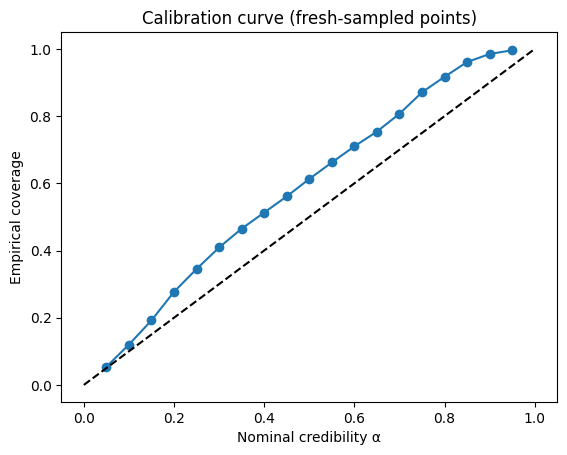

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_calibration_set(n=500):
    """
    Sample n fresh points (ω, b, ΔR, a) from the joint prior,
    compute their true flux, and build features X_calib, y_true.
    """
    # 1) rapidity → ω uniform in y∈[-4,4]
    ys    = np.random.uniform(-4, 4, n)
    ωs    = rapidity_to_omega(ys)
    logω  = np.log(ωs)

    # 2) fixed b (or sample b from Uniform[10,100] if you want to include b-var)
    b     = np.full(n, B_FIXED, dtype=np.float32)
    b_norm= np.zeros(n, dtype=np.float32)

    # 3) nuclear priors
    ΔR    = np.random.normal(DELTA_R_MEAN, DELTA_R_SIGMA, n)
    a_vals= np.random.normal(A_MEAN,       A_SIGMA,       n)
    ΔR_norm = ((ΔR - DELTA_R_MEAN)/DELTA_R_SIGMA).astype(np.float32)
    a_norm  = ((a_vals- A_MEAN)      /A_SIGMA).astype(np.float32)

    # 4) true flux via your real-space integrator
    flux_true = np.array([
        compute_eepa_flux_real(ωs[i], B_FIXED, 6.62+ΔR[i], a_vals[i])
        for i in range(n)
    ], dtype=np.float32)

    # 5) build feature matrix and log-target
    X_calib = np.vstack([logω, b_norm, ΔR_norm, a_norm]).T
    y_true  = np.log(flux_true + 1e-30).reshape(-1,1)

    return X_calib, y_true

def calibration_curve_random(model,
                             n_calib=500,
                             mc_samples=200,
                             cred_levels=None):
    """
    Generate fresh points, predict posteriors, and compute empirical coverage
    over a range of nominal credibility levels.
    """
    if cred_levels is None:
        cred_levels = np.linspace(0.05, 0.95, 19)

    Xc, y_true = generate_calibration_set(n_calib)

    # run MC-dropout predictions
    preds = []
    for _ in range(mc_samples):
        mu, _ = model(Xc, training=True)
        preds.append(mu.numpy().squeeze())
    P = np.stack(preds, axis=1)  # shape (n_calib, mc_samples)

    coverages = []
    for α in cred_levels:
        # lower and upper percentiles
        lo, hi = np.percentile(P,
                               [(1-α)/2*100, (1+(α))/2*100],
                               axis=1)
        cover = np.mean((y_true.squeeze() >= lo) & (y_true.squeeze() <= hi))
        coverages.append(cover)

    return cred_levels, coverages

# --- Example usage at the end of training ---
cred, cover = calibration_curve_random(model,
                                       n_calib=1000,
                                       mc_samples=300)
plt.figure()
plt.plot(cred, cover, 'o-')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Nominal credibility α')
plt.ylabel('Empirical coverage')
plt.title('Calibration curve (fresh-sampled points)')
plt.show()


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_vs_uncertainty(P, y_true, lower_pct=16, upper_pct=84, alpha=0.3):
    """
    Scatter-plot absolute prediction error versus predicted credible-interval width.

    Parameters
    ----------
    P : np.ndarray, shape (n_points, n_mc_samples)
        MC-dropout posterior samples of your log-flux for each test point.
    y_true : array-like, shape (n_points,)
        The true log-flux values.
    lower_pct, upper_pct : int
        Percentiles defining the central credible interval (e.g. 16,84 for 68%).
    alpha : float
        Marker transparency for the scatter plot.
    """
    # 1) Compute lower/upper bounds of the predicted interval
    lows  = np.percentile(P, lower_pct, axis=1)
    highs = np.percentile(P, upper_pct, axis=1)

    # 2) Interval width = uncertainty estimate
    widths = highs - lows

    # 3) Point estimate = posterior mean
    means = P.mean(axis=1)

    # 4) Absolute error of the point estimate
    errors = np.abs(means - np.array(y_true).squeeze())

    # 5) Scatter plot
    plt.figure()
    plt.scatter(widths, errors, alpha=alpha)
    plt.xlabel(f'Predicted {upper_pct-lower_pct}% interval width')
    plt.ylabel('Absolute error |predicted – true|')
    plt.title('Error vs. Predicted Uncertainty')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




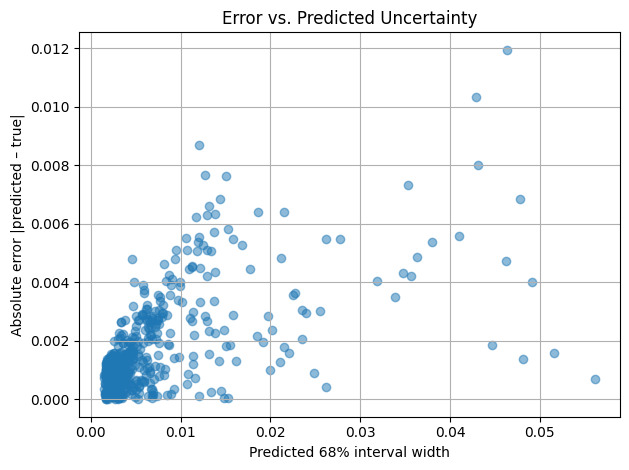

In [26]:
# --- 1) Generate a fresh calibration set ----------------
X_calib, y_calib = generate_calibration_set(n=500)  
# X_calib shape (500,4), y_calib shape (500,1)

# --- 2) Run MC-dropout to collect posterior samples ----
mc_samples = 200
P_list = []
for _ in range(mc_samples):
    mu, _ = model(X_calib, training=True)    # shape (500,1)
    P_list.append(mu.numpy().squeeze())       # make it (500,)

# Stack into an array of shape (500, 200)
P = np.stack(P_list, axis=1)  # each column is one dropout pass

# Flatten y_calib to shape (500,)
y_test = y_calib.squeeze()

# --- 3) Now call the plotting helper -------------------
plot_error_vs_uncertainty(P, y_test,
                         lower_pct=16,    # 68% interval
                         upper_pct=84,
                         alpha=0.5)


<>:55: SyntaxWarning: invalid escape sequence '\,'
<>:95: SyntaxWarning: invalid escape sequence '\,'
<>:55: SyntaxWarning: invalid escape sequence '\,'
<>:95: SyntaxWarning: invalid escape sequence '\,'
/var/folders/19/v4m73tyd09g0v7jcvl4r6jch0000gn/T/ipykernel_7667/1493600986.py:55: SyntaxWarning: invalid escape sequence '\,'
  plt.ylabel('$N(\\omega(y),\,b=20\\,$fm$)$')
/var/folders/19/v4m73tyd09g0v7jcvl4r6jch0000gn/T/ipykernel_7667/1493600986.py:95: SyntaxWarning: invalid escape sequence '\,'
  plt.ylabel(f'$N(\\omega={omega_fixed}\\,\\mathrm{{GeV}},\,b)$ [fm$^{{-2}}$]')


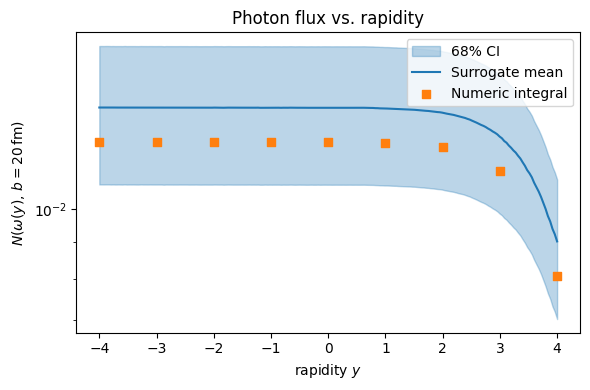

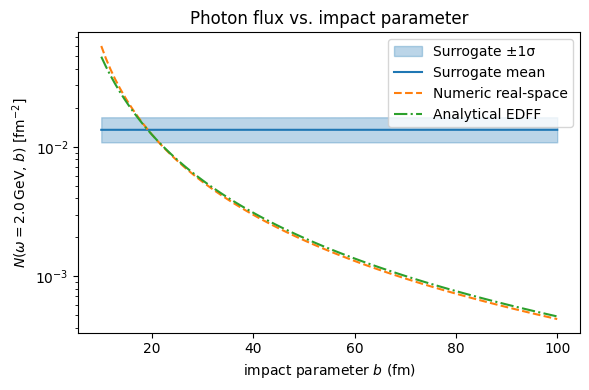

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumed available from your module ---
# model                 : trained BNN surrogate
# predict_with_uncertainty(model, X, n_samples)
# compute_eepa_flux_real(omega, b, R0, a)
# edff_flux(omega, b, R0, a)
# rapidity_to_omega(y)
# B_FIXED, R0_WS, A_MEAN, MC_SAMPLES

# 4.1.1 Flux vs Rapidity -----------------------------------------

# 1) Define rapidity grid
ys = np.linspace(-4, 4, 200)
omegas = rapidity_to_omega(ys)

# 2) Build feature matrix for surrogate: [logω, b_norm=0, ΔR_norm=0, a_norm=0]
X_y = np.vstack([
    np.log(omegas),
    np.zeros_like(ys, dtype=np.float32),
    np.zeros_like(ys, dtype=np.float32),
    np.zeros_like(ys, dtype=np.float32),
]).T.astype(np.float32)

# 3) MC-dropout prediction
mu_y, std_y = predict_with_uncertainty(model, X_y, n_samples=MC_SAMPLES)
# flux_pred   = np.exp(mu_y)
# flux_plus   = np.exp(mu_y + std_y)
# flux_minus  = np.exp(mu_y - std_y)

flux_pred   = np.exp(mu_y + 0.5 * std_y**2)
flux_plus  = np.exp(mu_y - std_y)
flux_minus  = np.exp(mu_y + std_y)


# 4) Ground-truth numeric integrals at a few points
ys_gt       = np.linspace(-4, 4, 9)
flux_gt     = np.array([
    compute_eepa_flux_real(rapidity_to_omega(y), B_FIXED, R0_WS, A_MEAN)
    for y in ys_gt
])

# 5) Plot
plt.figure(figsize=(6,4))
plt.fill_between(ys, flux_minus, flux_plus,
                 color='C0', alpha=0.3,
                 label='68% CI')
plt.plot(ys, flux_pred, 'C0-', label='Surrogate mean')


plt.scatter(ys_gt, flux_gt, c='C1', marker='s', label='Numeric integral')
plt.yscale('log')
plt.xlabel('rapidity $y$')
plt.ylabel('$N(\\omega(y),\,b=20\\,$fm$)$')
plt.title('Photon flux vs. rapidity')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('surrogate.pdf')


# 4.1.2 Flux vs Impact Parameter -------------------------------

# 1) Define b grid & fixed ω
bs = np.linspace(10, 100, 100)
omega_fixed = 2.0  # GeV

# 2) Surrogate prediction as a function of b:
X_b = np.vstack([
    np.full_like(bs, np.log(omega_fixed), dtype=np.float32),
    np.zeros_like(bs, dtype=np.float32),   # b_norm = 0 (we fix b in the surrogate)
    np.zeros_like(bs, dtype=np.float32),   # ΔR_norm
    np.zeros_like(bs, dtype=np.float32),   # a_norm
]).T

mu_b, std_b = predict_with_uncertainty(model, X_b, n_samples=MC_SAMPLES)
flux_b_pred  = np.exp(mu_b)
flux_b_plus  = np.exp(mu_b + std_b)
flux_b_minus = np.exp(mu_b - std_b)

# 3) Numeric and analytical benchmarks
flux_b_num   = [compute_eepa_flux_real(omega_fixed, b, R0_WS, A_MEAN)  for b in bs]
flux_b_edff  = [edff_flux(omega_fixed, b, R0_WS, A_MEAN)             for b in bs]

# 4) Plot
plt.figure(figsize=(6,4))
plt.fill_between(bs, flux_b_minus, flux_b_plus,
                 color='C0', alpha=0.3, label='Surrogate ±1σ')
plt.plot(bs, flux_b_pred, 'C0-', label='Surrogate mean')
plt.plot(bs, flux_b_num, 'C1--', label='Numeric real‐space')
plt.plot(bs, flux_b_edff,'C2-.', label='Analytical EDFF')
plt.yscale('log')
plt.xscale('linear')
plt.xlabel('impact parameter $b$ (fm)')
plt.ylabel(f'$N(\\omega={omega_fixed}\\,\\mathrm{{GeV}},\,b)$ [fm$^{{-2}}$]')
plt.title('Photon flux vs. impact parameter')
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()
